<center>Заметка 8.б Облако точек</center>
<center>курса <q>Введение в цифровую обработку изображений</q>.</center>
<center>Шокуров Антон В.</center>
<center>shokurov.anton.v@yandex.ru</center>
<center>http://машинноезрение.рф</center>
<center>Версия 0.09</center>

<center>Аннотация</center>
<p>
...
</p>

<p>Это предварительная версия! Любые замечания приветствуются.</p>

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MaxNLocator

In [2]:
import mpl_toolkits.mplot3d as plot3d
%matplotlib inline

<h2>Облако точек</h2>

<h3>Автоматизированное сопоставление точек</h3>

Рассмотрим один из известных методов сопостовления точек. Метод SIFT.

Метод SIFT (Scale-Invariant Feature Transform) - это алгоритм компьютерного зрения для извлечения ключевых точек из изображений и их дескрипторов. Он разработан для решения проблемы сопоставления изображений с разным масштабом и ориентацией.
Основная идея метода SIFT заключается в том, чтобы найти точки интереса на изображении, которые могут быть однозначно определены независимо от масштаба и ориентации изображения. Затем для каждой точки интереса вычисляется локальный дескриптор, который описывает окрестность этой точки и может быть использован для сопоставления с другими изображениями.



In [3]:
rec_img1 = cv.imread("./rec_img1.bmp")
rec_img2 = cv.imread("./rec_img2.bmp")

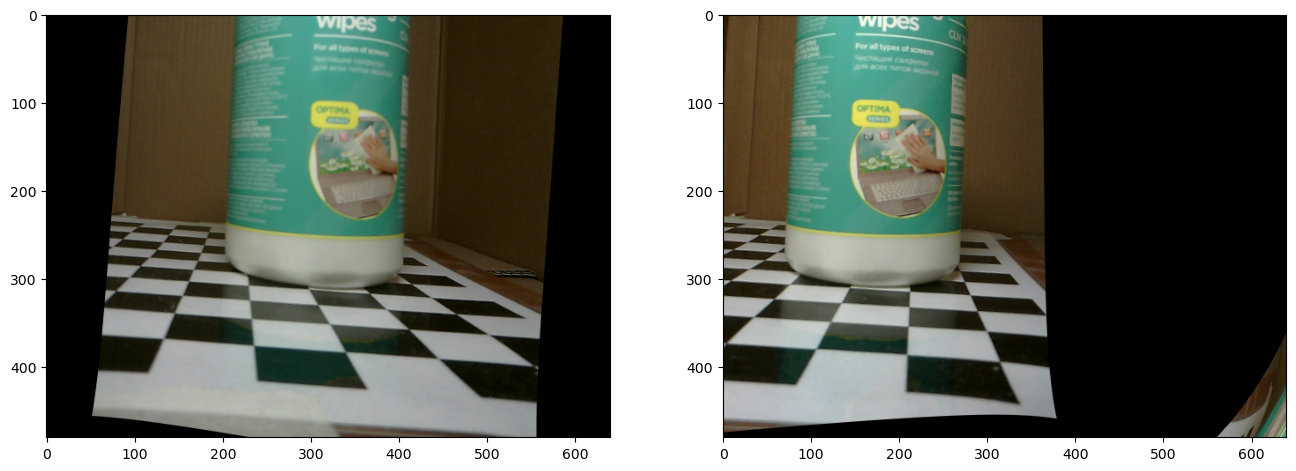

In [4]:
fig, axs = plt.subplots( 1, 2 )
fig.set_size_inches( (16, 16) )
axs[0].imshow( cv.rotate( rec_img1, cv.ROTATE_90_COUNTERCLOCKWISE ) )
axs[1].imshow( cv.rotate( rec_img2, cv.ROTATE_90_COUNTERCLOCKWISE ) );

In [5]:
imgL = cv.cvtColor( rec_img1.copy(), cv.COLOR_RGB2GRAY)
imgR = cv.cvtColor( rec_img2.copy(), cv.COLOR_RGB2GRAY)

Для простоты не будем включать шахматные доски в изображения. Поэтому кадрируем нужную нам часть объекта.

In [6]:
imL = imgL[200:430,200:]
imR = imgR[65:295,200:]

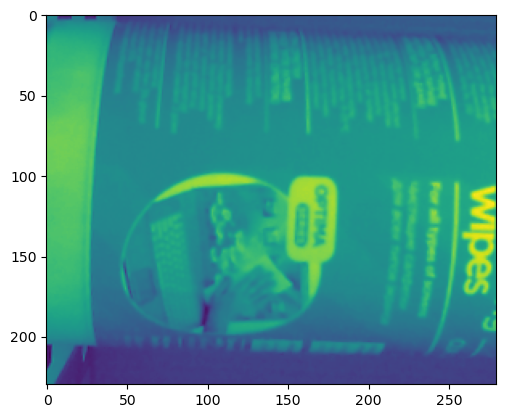

In [7]:
plt.imshow( imL );

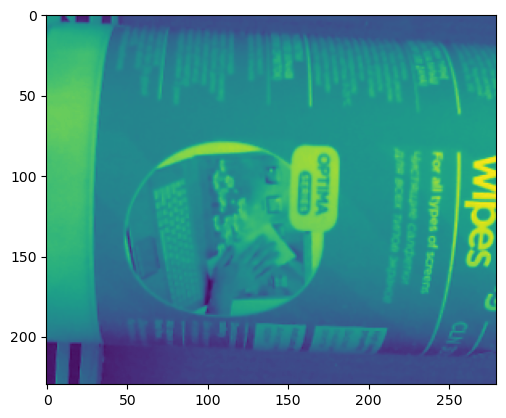

In [8]:
plt.imshow( imR );

Создадим класс SIFT отвечающий за поиск и построения дискриптеров точек.

In [9]:
sift = cv.SIFT_create()

Одновременно найдем хорошие точки и вычислим для них дискриптеры.

In [10]:
# Подается изображения на котором искать.
# Возвращается список точек и их дискрипторы.
kp, des = sift.detectAndCompute( imL, None)
kp2, des2 = sift.detectAndCompute( imR, None)


Выполним отрисовку ключевых точек.

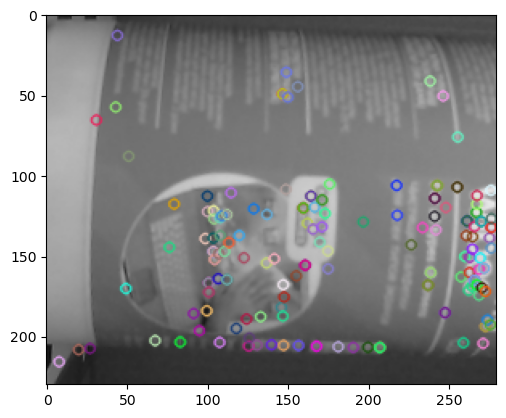

In [11]:
img = cv.drawKeypoints( imL, kp, imL.copy())
plt.imshow(img);

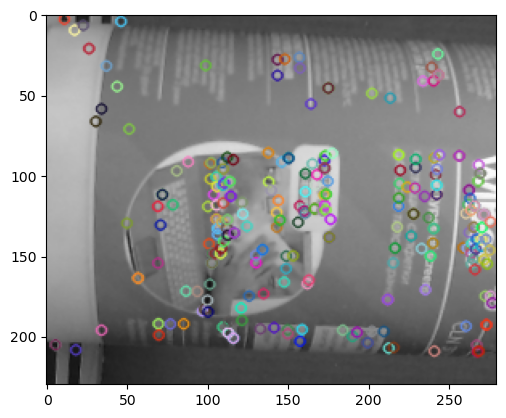

In [12]:
img=cv.drawKeypoints( imR, kp2, imR.copy())
plt.imshow(img);

Создадим объект который и будет использоватся для сопоставления точек. Будем использовать BFMatcher (Brute-force descriptor matcher). Для каждого дескриптора в первом наборе BFMatcher находит ближайший дескриптор во втором наборе, перебирая каждый из них.

In [13]:
bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)

Функции match подаются два списка дискрипторов.

In [14]:
matches = bf.match(des, des2)

Атрибут distance возвращает расстояние между дискрипторами.

In [15]:
matches[3].distance

695.0

Индекс изображения на котором была взята ключевая точка.

In [16]:
matches[5].imgIdx

0

Индексы ключевых точек на исходном и на втором изображении.

In [17]:
matches[5].trainIdx, matches[5].queryIdx

(16, 7)

Точки сортируются по близости дискрипторов.

In [18]:
matches = sorted(matches, key = lambda x:x.distance)

Отрисовываем первые 20 из списка. т.е. 20 наилучших сопоставления.

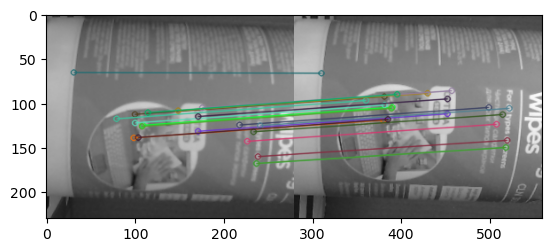

In [19]:
img3 = cv.drawMatches(imL, kp, imR, kp2, matches[:20], imR, flags=2)
plt.imshow(img3);

<h3>Восстановление 3д для стерео пары</h3>

Для начала обнулим массив глубины.

In [20]:
data = np.zeros( (50, 3) )

Пробегаем 50 лучших сопоставлений и на основании их координат строим глубину.

In [21]:
for i in range(50):
    p1 = kp[matches[i].queryIdx].pt
    p2 = kp2[matches[i].trainIdx].pt
    # Разница координат [1] дает глубину.
    data[i] = [ p1[0], p1[1] ,p1[1]-p2[1]]

<b>Отобразим облако найденных точек</b>

In [30]:
%matplotlib ipympl
%pylab

Using matplotlib backend: module://ipympl.backend_nbagg
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


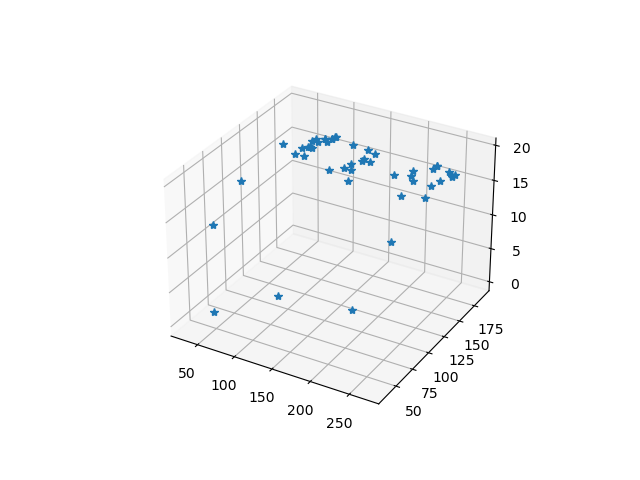

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot3D( data[:,0], data[:,1], data[:,2], '*');